In [1]:
import os
import os.path as osp
import argparse
from cv2 import imread, normalize, resize
import cv2
import json
import numpy as np
import time
import datetime
import random
import logging
import sys
from PIL import Image
from pytorchtools import EarlyStopping # 위 링크의 깃허브 파일에서 임포트
from utils import euclidean_metric, one_hot, count_acc
from utils import pprint, set_gpu, ensure_path, AverageMeter, Timer, accuracy, one_hot

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch import nn, optim, autograd
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision
from random import sample, random

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset, TensorDataset, WeightedRandomSampler
import os.path as osp
from tqdm import tqdm

from random import sample, random

batch_size = 32
num_epoch = 100

/home/iai/anaconda3/envs/sh_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Customdataset(data.Dataset):
    def __init__(self,transform = None):
        dalist=None
        self.file_paths = []
        self.label = []
        self.concept = []
        self.transform = transform

        folder_list = ["custom_blur","custom_brightness","custom_cameraz","custom_lightness"]
        
        for folder_name in folder_list:
            path_dir = "/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/augmented_image2/train1-1/" +  folder_name
            file_list = os.listdir(path_dir)
            
            for file_name in file_list:
                self.file_paths.append(path_dir + '/' + file_name)
                self.label.append(file_name.split('_')[-1][0])
                
                if str(file_name.split('_')[2]) == 'cameraz':
                    self.concept.append(3)
                    
                elif str(file_name.split('_')[2]) == 'blur':
                    self.concept.append(3)
                    
                elif str(file_name.split('_')[2]) == 'brigntness':
                    self.concept.append(2)
                    
                    
                elif str(file_name.split('_')[2]) == 'lightness':
                    self.concept.append(1)

        
        
        file_path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/imageset/single_image.2class.subject-split.trainval-repeat0/fold.5-5/ratio/100%/train.1-1.txt' # 폴더 경로

        with open(file_path) as f:
            lines = f.readlines()

        image_names = [line.rstrip('\n') for line in lines]
        
                
        with open('/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/annotation/single_image.6class.json', 'r') as json_file:
            data = json.load(json_file)
            
        path_image = "/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/image/"
        files = os.listdir(path_image)
        
        for file in files:
            if file in image_names:
                self.label.append(data['single_image'][file]['class'][0])
                self.file_paths.append(path_image + '/' + file)
                self.concept.append(0)
        
        
                
        file_path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/imageset/single_image.2class.subject-split.trainval-repeat0/fold.5-5/ratio/100%/validation.1-1.txt' # 폴더 경로

        for folder_name in folder_list:
            path_dir = "/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/augmented_image2/train1-1/" +  folder_name
            file_list = os.listdir(path_dir)
            
            for file_name in file_list:
                self.file_paths.append(path_dir + '/' + file_name)
                self.label.append(file_name.split('_')[-1][0])
                
                if str(file_name.split('_')[2]) == 'cameraz':
                    self.concept.append(3)
                    
                elif str(file_name.split('_')[2]) == 'blur':
                    self.concept.append(3)
                    
                elif str(file_name.split('_')[2]) == 'brigntness':
                    self.concept.append(2)
                    
                    
                elif str(file_name.split('_')[2]) == 'lightness':
                    self.concept.append(1)
        
        with open(file_path) as f:
            lines = f.readlines()

        image_names = [line.rstrip('\n') for line in lines]
        
                
        with open('/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/annotation/single_image.6class.json', 'r') as json_file:
            data = json.load(json_file)
            
        path_image = "/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/image/"
        files = os.listdir(path_image)
        
        for file in files:
            if file in image_names:
                self.label.append(data['single_image'][file]['class'][0])
                self.file_paths.append(path_image + '/' + file)
                self.concept.append(0) 

    def __len__(self):

        return len(self.file_paths)

    def __getitem__(self, idx):
        
        label = self.label[idx]
        idx_num = idx
        tmp_prob = np.random.rand()
        weight_dict = {"0" :  (400/250) / (400/250 + 400 * 5 / 30), "1" : (400/30) / (400/250 + 400 * 5 / 30), "2" : (400/30) / (400/250 + 400 * 5 / 30), 
                       "3" : (400/30) / (400/250 + 400 * 5 / 30), "4" : (400/30) / (400/250 + 400 * 5 / 30), "5" : (400/30) / (400/250 + 400 * 5 / 30)}        
        
        if weight_dict[str(label)] > tmp_prob:
            while True : 
                idx_num = np.random.randint(len(self.file_paths))
                tmp_prob =  np.random.rand()
                label = self.label[idx_num]
                
                if weight_dict[str(label)] < tmp_prob:
                    break
        
        
        path = self.file_paths[idx_num]
        image = Image.open(path).convert('RGB')
        concept = self.concept[idx_num]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, int(label), int(concept)

In [3]:
data_transforms = transforms.Compose([
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),

        ])

In [4]:
##커스텀 데이터셋
dataset = Customdataset(transform=data_transforms)
train_size = int(0.8 * len(dataset))
print(f"train size :{train_size}")
val_size = len(dataset) - train_size
print(f"test_size :{val_size}")
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"train_dataset :{len(train_dataset)}")
print(f'test dataset :{len(val_dataset)}')

train size :8576
test_size :2144
train_dataset :8576
test dataset :2144


In [5]:

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size, #배치사이즈
                                               shuffle = True 
                                               )

val_loader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,                                              
                                               shuffle = True 
                                              )

In [6]:
class bgor2(nn.Module):
    def __init__(self):
        super().__init__()

        num_class = 6     
        num_concept = 4
    
        hdim = 512
        resnet50 = models.resnet50(pretrained=True)
        backbone = resnet50
        #backbone.load_state_dict(torch.load('/home/woonglab/sh/DecAug/saves/initialization/resnet18.pth'), strict=False)
        hdim_i = backbone.fc.in_features
        
        self.encoder = backbone
        self.encoder.fc = nn.Linear(hdim_i, hdim)


        self.softmax = nn.Softmax(dim=1)

        self.category_branch = nn.Linear(hdim, hdim)
        self.concept_branch = nn.Linear(hdim, hdim)

        self.relu = nn.ReLU(inplace=True)

        self.fc0 = nn.Linear(hdim, num_class)
        self.fcc0 = nn.Linear(hdim, num_concept)

        self.classification = nn.Linear(hdim * 2, num_class)

    def forward(self, x):

        x = x.squeeze(0)
        B, _, _, _ = x.shape
        
        instance_embs = self.encoder(x)
        instance_embs = torch.reshape(instance_embs, (B, -1))

        category_embs = self.category_branch(instance_embs)

        logits_category = self.fc0(category_embs)
        logits_category = self.softmax(logits_category)


        concept_embs = self.concept_branch(instance_embs)

        logits_concept = self.fcc0(concept_embs)
        logits_concept = self.softmax(logits_concept)

        fused_embs = torch.cat((category_embs, concept_embs), 1)
        
        logits = self.classification(fused_embs)
        logits = self.softmax(logits)


        return logits, logits_category, logits_concept, fused_embs, category_embs, concept_embs

model = bgor2()

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    model = model.cuda()

In [7]:
epsilon = 1e-8
perturbation = 1
balance1 = 0.01
balance2 = 0.01
balanceorth = 0.01

model_path = '/home/iai/Desktop/SH/cognex/model/'
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.05, momentum=0.9, nesterov=True, weight_decay=0.0005) 
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)


early_stopping = EarlyStopping(patience = 4, verbose = True, min_epoch=20)

global_count = 0
device = torch.device('cuda:0')

train_loss_arr =[]
val_loss_arr =[]
n = len(train_loader)
model.to(device)

val_acc =[]
val_concept = []
val_category = []

for epoch in range(1, 100 + 1):
    epoch_start = time.time()
    model.train()

    '''
    for i, batch in enumerate(train_loader, 1):
        batch_start = time.time()
        global_count = global_count + 1
        if torch.cuda.is_available():
            data, gt_label, gt_concept = [_.cuda() for _ in batch]
        else:
            data, gt_label, gt_concept = batch[0], batch[1], batch[2]
    '''
    train_running_loss = 0.0   
    for i,[image,label, concept] in enumerate(train_loader):
       
        data = image.to(device)
        gt_label = label.to(device)
        gt_concept = concept.to(device)

    

        logits, logits_category, logits_concept, feature, feature_category, feature_concept = model(data)
        loss1 = F.cross_entropy(logits_category, gt_label)
        loss2 = F.cross_entropy(logits_concept, gt_concept)

        parm = {}
        for name, parameters in model.named_parameters():
            parm[name] = parameters
        # concept branch
        w_branch = parm['concept_branch.weight']
        w_tensor = parm['fcc0.weight']
        b_tensor = parm['fcc0.bias']
        # classification branch
        w_branch_l = parm['category_branch.weight']
        w_tensor_l = parm['fc0.weight']
        b_tensor_l = parm['fc0.bias']

        w_out = parm['classification.weight']
        b_out = parm['classification.bias']

        w = torch.matmul(w_tensor, w_branch)
        grad = -1 * w[gt_concept] + torch.matmul(logits_concept.detach(), w)
        grad_norm = grad / (grad.norm(2, dim=1, keepdim=True) + epsilon)

        w_l = torch.matmul(w_tensor_l, w_branch_l)
        grad_l = -1 * w_l[gt_label] + torch.matmul(logits_category.detach(), w_l)
        grad_norm_l = grad_l / (grad_l.norm(2, dim=1, keepdim=True) + epsilon)
        b, L = grad_norm_l.shape

        grad_norm = grad_norm.reshape(b, 1, L)
        grad_norm_l = grad_norm_l.reshape(b, L, 1)
        loss_orth = ((torch.bmm(grad_norm, grad_norm_l).cuda()) ** 2).sum()

        grad_aug = -1 * w_tensor[gt_concept] + torch.matmul(logits_concept.detach(), w_tensor)
        FGSM_attack = perturbation * (grad_aug.detach() / (grad_aug.detach().norm(2, dim=1, keepdim=True) +  epsilon))
        ratio = np.random.random()

        feature_aug = ratio * FGSM_attack
        embs = torch.cat((feature_category, feature_concept + feature_aug), 1)

        output = torch.matmul(embs, w_out.transpose(0, 1)) + b_out

        logits_class = output

        loss_class = F.cross_entropy(logits_class, gt_label)
        loss = loss_class + balance1 * loss1 + balance2 * loss2 + balanceorth * loss_orth


        acc = accuracy(logits_class.data, gt_label.data, topk=(1,))[0]
        acc_concept = accuracy(logits_concept.data, gt_concept.data, topk=(1,))[0]
        acc_category = accuracy(logits_category.data, gt_label.data, topk=(1,))[0]
    
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        torch.cuda.synchronize()
        train_running_loss += loss.item()

        #if (i) % 100 == 0:
        #    print('epoch {}. train {}/{}, loss={:.4f}, acc={:.4f}, acc_concept={:.4f}, acc_category={:.4f}'.format(epoch, i, len(train_loader), loss.item(), float(acc), float(acc_concept), float(acc_category)))
    
    train_loss_arr.append(train_running_loss / n)
    #lr_scheduler.step()
    
    val_running_loss = 0.0
    with torch.no_grad():
        for i,[image,label, concept] in enumerate(val_loader):
       
            data = image.to(device)
            gt_label = label.to(device)
            gt_concept = concept.to(device)


            logits, logits_category, logits_concept, feature, feature_category, feature_concept = model(data)

            loss1 = F.cross_entropy(logits_category, gt_label)
            loss2 = F.cross_entropy(logits_concept, gt_concept)

            parm = {}
            for name, parameters in model.named_parameters():
                parm[name] = parameters
            # concept branch
            w_branch = parm['concept_branch.weight']
            w_tensor = parm['fcc0.weight']
            b_tensor = parm['fcc0.bias']
            # classification branch
            w_branch_l = parm['category_branch.weight']
            w_tensor_l = parm['fc0.weight']
            b_tensor_l = parm['fc0.bias']

            w_out = parm['classification.weight']
            b_out = parm['classification.bias']

            w = torch.matmul(w_tensor, w_branch)
            grad = -1 * w[gt_concept] + torch.matmul(logits_concept.detach(), w)
            grad_norm = grad / (grad.norm(2, dim=1, keepdim=True) + epsilon)

            w_l = torch.matmul(w_tensor_l, w_branch_l)
            grad_l = -1 * w_l[gt_label] + torch.matmul(logits_category.detach(), w_l)
            grad_norm_l = grad_l / (grad_l.norm(2, dim=1, keepdim=True) + epsilon)
            b, L = grad_norm_l.shape

            grad_norm = grad_norm.reshape(b, 1, L)
            grad_norm_l = grad_norm_l.reshape(b, L, 1)
            loss_orth = ((torch.bmm(grad_norm, grad_norm_l).cuda()) ** 2).sum()

            grad_aug = -1 * w_tensor[gt_concept] + torch.matmul(logits_concept.detach(), w_tensor)
            FGSM_attack = perturbation * (grad_aug.detach() / (grad_aug.detach().norm(2, dim=1, keepdim=True) +  epsilon))
            ratio = np.random.random()

            feature_aug = ratio * FGSM_attack
            embs = torch.cat((feature_category, feature_concept), 1)
            output = torch.matmul(embs, w_out.transpose(0, 1)) + b_out
            logits_class = output

            loss_class = F.cross_entropy(logits_class, gt_label)
            loss = loss_class + balance1 * loss1 + balance2 * loss2 + balanceorth * loss_orth
            val_running_loss += loss.item()
        
        acc = accuracy(logits_class.data, gt_label.data, topk=(1,))[0]
        acc_concept = accuracy(logits_concept.data, gt_concept.data, topk=(1,))[0]
        acc_category = accuracy(logits_category.data, gt_label.data, topk=(1,))[0]               
        
        val_loss_arr.append(val_running_loss / len(val_loader)) 
        val_acc.append(acc)
        val_concept.append(acc_concept)
        val_category.append(acc_category)

        early_stopping(val_running_loss, model)
        torch.save(model, model_path + str(epoch-1) + 'epoch_model.pt')
        
        print('[%d] train_loss: %.3f , val_loss: %.3f , val_acc: %.1f , val_concep_acc: %.1f , val_category_acc: %.1f' 
              %(epoch, train_running_loss / len(train_loader) , val_running_loss / len(val_loader) ,float(acc), float(acc_concept), float(acc_category)))
        
        if early_stopping.early_stop and i > 20: # 조건 만족 시 조기 종료
            break
        

Validation loss decreased (inf --> 2.881208).  Saving model ...
[1] train_loss: 0.409 , val_loss: 0.043 , val_acc: 100.0 , val_concep_acc: 50.0 , val_category_acc: 87.5
Not enough epoch
[2] train_loss: 0.029 , val_loss: 0.053 , val_acc: 100.0 , val_concep_acc: 59.4 , val_category_acc: 100.0
Validation loss decreased (2.881208 --> 1.953626).  Saving model ...
[3] train_loss: 0.037 , val_loss: 0.029 , val_acc: 100.0 , val_concep_acc: 53.1 , val_category_acc: 100.0
Not enough epoch
[4] train_loss: 0.024 , val_loss: 0.031 , val_acc: 100.0 , val_concep_acc: 40.6 , val_category_acc: 100.0
Not enough epoch
[5] train_loss: 0.025 , val_loss: 0.044 , val_acc: 100.0 , val_concep_acc: 46.9 , val_category_acc: 96.9
Not enough epoch
[6] train_loss: 0.037 , val_loss: 0.029 , val_acc: 100.0 , val_concep_acc: 37.5 , val_category_acc: 100.0
Not enough epoch
[7] train_loss: 0.029 , val_loss: 0.036 , val_acc: 100.0 , val_concep_acc: 43.8 , val_category_acc: 100.0
Not enough epoch
[8] train_loss: 0.030 , v

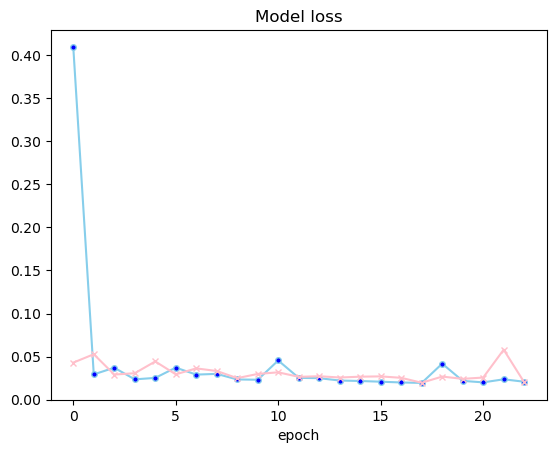

In [8]:
import matplotlib.pyplot as plt


plt.plot(train_loss_arr,
         color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=4)

plt.plot(val_loss_arr,
         color='pink',
         marker='x', markerfacecolor='red',
         markersize=4)

plt.title('Model loss')
plt.xlabel('epoch')
plt.show()

In [9]:
import torch.utils.data as data

class Customdataset(data.Dataset):
    def __init__(self,transform = None):
        dalist=None
        self.file_paths = []
        self.label = []
        self.concept = []
        self.transform = transform

        file_path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/imageset/single_image.2class.subject-split.trainval-repeat0/fold.5-5/ratio/100%/test.1.txt' # 폴더 경로

        with open(file_path) as f:
            lines = f.readlines()

        image_names = [line.rstrip('\n') for line in lines]


        path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/image' # 폴더 경로
        files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
        
        with open('/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/annotation/single_image.6class.json', 'r') as json_file:
            data = json.load(json_file)  
    
        for file in files:
            if file in image_names:
                self.label.append(data['single_image'][file]['class'][0])
                self.file_paths.append(path + '/' + file)
                
                if str(file.split('_')[1]) == 'cameraz':
                    self.concept.append(3)
                    
                elif str(file.split('_')[1]) == 'repeat':
                    self.concept.append(0)
                    
                elif str(file.split('_')[1]) == 'brightness':
                    self.concept.append(2)
                    
                elif str(file.split('_')[1]) == 'lcondition':
                    self.concept.append(1)
                    
        print(len(concept))
        print(len(label))
        print(len(file_path))
        
    def __len__(self):

        return len(self.concept)


    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]
        concept = self.concept[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, int(label) , int(concept)
    
    
test_dataset = Customdataset(transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 32                                       
                                              )

32
32
144


In [10]:
##커스텀 데이터셋
dataset = Customdataset(transform=data_transforms)


print(f"train_dataset :{len(dataset)}")



32
32
144
train_dataset :1600


In [11]:
model = bgor2()

best_model_epoch = val_loss_arr.index(min(val_loss_arr))
model = torch.load(model_path + str(best_model_epoch) +'epoch_model.pt')
model.to(device)

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    model = model.cuda()

In [17]:
best_model_epoch

17

In [12]:
from sklearn.metrics import accuracy_score

test_acc_ls = [] 
pred_ls = []
real_ls = [] 
correct = 0
total = 0

with torch.no_grad():
        for i,[image,label, concept] in enumerate(test_loader):
       
            data = image.to(device)
            gt_label = label.to(device)
            gt_concept = concept.to(device)


            logits, logits_category, logits_concept, feature, feature_category, feature_concept = model(data)

            loss1 = F.cross_entropy(logits_category, gt_label)
            loss2 = F.cross_entropy(logits_concept, gt_concept)

            parm = {}
            for name, parameters in model.named_parameters():
                parm[name] = parameters
            # concept branch
            w_branch = parm['concept_branch.weight']
            w_tensor = parm['fcc0.weight']
            b_tensor = parm['fcc0.bias']
            # classification branch
            w_branch_l = parm['category_branch.weight']
            w_tensor_l = parm['fc0.weight']
            b_tensor_l = parm['fc0.bias']

            w_out = parm['classification.weight']
            b_out = parm['classification.bias']

            w = torch.matmul(w_tensor, w_branch)
            grad = -1 * w[gt_concept] + torch.matmul(logits_concept.detach(), w)
            grad_norm = grad / (grad.norm(2, dim=1, keepdim=True) + epsilon)

            w_l = torch.matmul(w_tensor_l, w_branch_l)
            grad_l = -1 * w_l[gt_label] + torch.matmul(logits_category.detach(), w_l)
            grad_norm_l = grad_l / (grad_l.norm(2, dim=1, keepdim=True) + epsilon)
            b, L = grad_norm_l.shape

            grad_norm = grad_norm.reshape(b, 1, L)
            grad_norm_l = grad_norm_l.reshape(b, L, 1)
            loss_orth = ((torch.bmm(grad_norm, grad_norm_l).cuda()) ** 2).sum()

            grad_aug = -1 * w_tensor[gt_concept] + torch.matmul(logits_concept.detach(), w_tensor)
            FGSM_attack = perturbation * (grad_aug.detach() / (grad_aug.detach().norm(2, dim=1, keepdim=True) +  epsilon))
            ratio = np.random.random()

            feature_aug = ratio * FGSM_attack
            embs = torch.cat((feature_category, feature_concept), 1)
            output = torch.matmul(embs, w_out.transpose(0, 1)) + b_out
            logits_class = output
            pred = output.argmax(dim=1)
            
            pred_ls.append(pred.cpu().numpy())
            real_ls.append(gt_label.cpu().numpy())
            
        acc = accuracy(logits_class.data, gt_label.data, topk=(1,))[0]
        acc_concept = accuracy(logits_concept.data, gt_concept.data, topk=(1,))[0]
        acc_category = accuracy(logits_category.data, gt_label.data, topk=(1,))[0]
        
print(acc)
print(acc_concept)
print(acc_category)

tensor(90.6250, device='cuda:0')
tensor(40.6250, device='cuda:0')
tensor(90.6250, device='cuda:0')


In [13]:
pred = np.array(pred_ls).reshape(-1)
real = np.array(real_ls).reshape(-1)

In [14]:
accuracy_score(pred,real)

0.87625

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(pred, real))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1082
           1       0.59      0.79      0.68        90
           2       0.93      0.90      0.91       123
           3       0.74      0.83      0.78       107
           4       0.41      0.75      0.53        65
           5       1.00      0.90      0.95       133

    accuracy                           0.88      1600
   macro avg       0.77      0.84      0.80      1600
weighted avg       0.90      0.88      0.89      1600



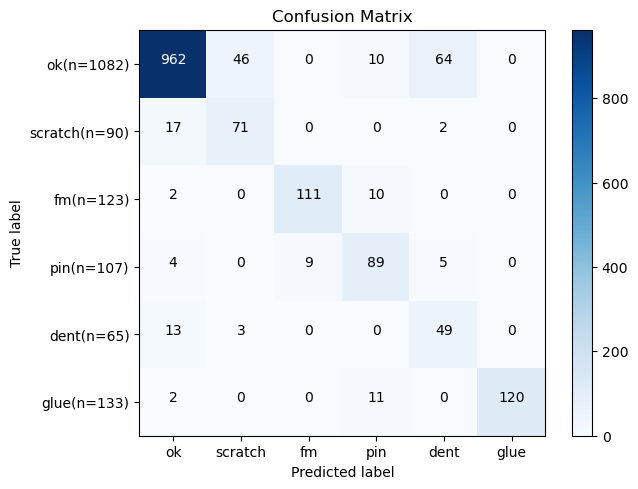

In [16]:
import itertools

def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_df = confusion_matrix(pred, real)    
label=['ok', 'scratch', 'fm', 'pin', 'dent', 'glue']
plot_confusion_matrix(cm_df, labels=label, normalize=False)